In [139]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import matplotlib.pyplot as plt             #visualisation
import seaborn as sns   #visualisation
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline     
sns.set(color_codes=True)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise Exception("Cry about it")


In [63]:
def add_cell_prefix(df, prefix):
    df.index = [prefix + i for i in df.index]
    return df

#Remove extra quotes from the filenames
def extract_cell_name_smartseq(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name_smartseq(file_name):
    return extract_cell_name_smartseq(file_name)

def convert_indexes_to_cell_names_smartseq(df):
    df.index = [get_cell_name_smartseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_smartseq(df_meta, cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm_smartseq(df, df_meta):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Norm" or get_cell_hypo_or_norm_smartseq(df_meta, x)=="Normo")]
    return df_hypo, df_norm

def process_df_smartseq(df, df_meta, prefix):
    df = convert_indexes_to_cell_names_smartseq(df)
    _, df_norm = seperate_hypo_and_norm_smartseq(df,df_meta)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

#Remove extra quotes from the filenames
def extract_cell_name_dropseq(x):
    y = x.split("_")
    return y[0]

def get_cell_name_dropseq(file_name):
    return extract_cell_name_dropseq(file_name)

def convert_indexes_to_cell_names_dropseq(df):
    df.index = [get_cell_name_dropseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_dropseq(cell_name):
    return cell_name.split("_")[-1]

def seperate_hypo_and_norm_dropseq(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Hypoxia")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Normoxia")]
    return df_hypo, df_norm

def process_df_dropseq(df, prefix):
    _, df_norm = seperate_hypo_and_norm_dropseq(df)
    df = convert_indexes_to_cell_names_dropseq(df)
    df_norm = convert_indexes_to_cell_names_dropseq(df_norm)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

In [60]:
df_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t", index_col=0)
dffn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df2_meta = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_MetaData.tsv",delimiter="\t",index_col=0)
df2fn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df3 = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df4 = pd.read_csv("Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T

In [64]:
dffn, dffn_norm_idx = process_df_smartseq(dffn.copy(), df_meta, "MCF7_")
df2fn, df2fn_norm_idx = process_df_smartseq(df2fn.copy(), df2_meta, "HCC1806_")
df3, df3_norm_idx = process_df_dropseq(df3, "MCF7_")
df4, df4_norm_idx = process_df_dropseq(df4, "HCC1806_")

In [67]:
df3

,MALAT1,MT-RNR2,NEAT1,H1-5,TFF1,MT-RNR1,H4C3,GDF15,KRT81,MT-CO3,...,MROH1,SKIDA1,MICALL1,RARG,MYO1F,BRWD1-AS2,RPS19BP1,AUNIP,TNK2,SUDS3
MCF7_AAAAACCTATCG,1,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_AAAACAACCCTA,3,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_AAAACACTCTCA,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_AAAACCAGGCAC,6,2,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_AAAACCTAGCTC,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MCF7_TTTTCGCGTAGA,0,0,0,0,3,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_TTTTCGTCCGCT,1,0,0,0,4,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_TTTTCTCCGGCT,0,0,0,1,2,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,1
MCF7_TTTTGTTCAAAG,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
df_drop_norm_idx = np.concatenate([df3_norm_idx, df4_norm_idx])
df_smart_norm_idx = np.concatenate([dffn_norm_idx, df2fn_norm_idx])
df_smart_idx = np.concatenate([dffn.index, df2fn.index])

df_all = pd.concat([dffn, df2fn, df3, df4])
df_all = df_all.fillna(0)

df_all_norm_idx = np.concatenate([dffn_norm_idx, df2fn_norm_idx, df3_norm_idx, df4_norm_idx])

df_MCF7_idx = [idx for idx in df_all.index if "MCF7" in idx]


In [69]:
df_all["mcf"] = ["MCF7" in idx for idx in df_all.index]
df_all["smart"] = [idx in df_smart_idx for idx in df_all.index]

In [70]:
df_all = df_all.astype(np.int32)

In [71]:
# Free up memory
del dffn, df2fn, df3, df4, dffn_norm_idx, df2fn_norm_idx, df3_norm_idx, df4_norm_idx, df_meta, df2_meta

In [90]:
class NNDataset(Dataset):
    def __init__(self, df, df_norm_idx):
        self.data = df.values  # Convert DataFrame to numpy array
        self.data_norm = df_norm_idx
        self.idx = df.index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        dat = self.data[index, :]
        x = torch.tensor(dat, dtype=torch.float32, device=device)
        y = torch.tensor(0 if self.idx[index] in self.data_norm else 1,  dtype=torch.float32, device=device)
        return x, y

# Define the architecture of the autoencoder
class NNClassifier(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNClassifier, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_size, H1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H1, H1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H2, H2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H3, H3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [224]:
@torch.no_grad
def measure_model_log(writer, model, data_loader, epoch):
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    if(np.isnan(y_pred_class).any()):
        print("Found nan, skipping evaluation")
        return 
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    writer.add_scalar("F1 Score", f1, epoch)
    writer.add_scalar("Recall", recall, epoch)
    writer.add_scalar("Accuracy", accuracy, epoch)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    fig = plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    writer.add_figure("Confusion Matrix", fig, epoch)

    fig = plt.figure(figsize = (12,7))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    writer.add_figure("ROC Curve", fig, epoch)


@torch.no_grad
def measure_model(model, data_loader):
    plt.close()
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted +0.5 > labels).sum().item()
        y_pred_class.extend(predicted.cpu().round()) # Save Prediction
        y_pred.extend(predicted.cpu()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    
    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    print("F1 Score:", f1_score(y_true, y_pred_class))
    print("Recall:", recall_score(y_true, y_pred_class))
    print(f'Accuracy of the network on the {total} test images: {(correct / total) * 100}%')


In [225]:
input_size = df_all.shape[1]
learning_rate = 1e-2

hidden_size = 1024
hidden_size1 = 512
hidden_size2 = 256

test_amount = 0.2

In [226]:
df_train, df_test = train_test_split(df_all, test_size=test_amount)

In [227]:
dataset = NNDataset(df_train, df_all_norm_idx)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [228]:
dataset_test = NNDataset(df_test, df_all_norm_idx)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

df_test_smart = df_test[[i in df_smart_idx for i in df_test.index]]
df_test_drop = df_test[[i not in df_smart_idx for i in df_test.index]]

dataset_test_smart = NNDataset(df_test_smart, df_smart_norm_idx)
dataset_test_drop = NNDataset(df_test_drop, df_drop_norm_idx)

test_loader_smart = DataLoader(dataset_test_smart, batch_size=64, shuffle=True)
test_loader_drop = DataLoader(dataset_test_drop, batch_size=64, shuffle=True)

In [235]:
# Define the model
model = NNClassifier(input_size, hidden_size, hidden_size1, hidden_size2).to(device)
writer = SummaryWriter()

In [236]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()


In [237]:
lr_sgd = 1e-2
lr_adm = 1e-3
lr_ada = 1e-2

# Define the optimizer
sgd = optim.SGD(model.parameters(), lr=lr_sgd)
adam = optim.Adam(model.parameters(), lr=lr_adm)
ada = optim.Adagrad(model.parameters(), lr=lr_ada)

In [238]:
model

NNClassifier(
  (layers): Sequential(
    (0): Linear(in_features=8647, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=256, out_features=256, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [239]:
train_config = [
    [1000, data_loader, sgd]
]

In [240]:
total_epochs = 0
# Training loop
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    optimizer = segment[2]
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for inputs, labels in data_loaderr:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss = criterion(outputs[:, 0], labels)

            # Backward pass and optimize
            loss.backward()

            # Clip gradients
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            # Print statistics
            running_loss += loss.item()

        writer.add_scalar("Loss/train", running_loss/len(data_loader), epoch)
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(data_loader)}", flush=True)
        measure_model_log(writer, model, test_loader, total_epochs)
        writer.flush()
        total_epochs += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss: 0.7402613971544348
F1 Score: 0.05903866248693835
Recall: 0.03151143335192415
Accuracy on test: 50.97985846488841%


  0%|          | 1/1000 [00:15<4:15:25, 15.34s/it]

Epoch 2, Loss: 0.7280631617359493
F1 Score: 0.07529654461062403
Recall: 0.04071388733965421
Accuracy on test: 51.19760479041916%


  0%|          | 2/1000 [00:28<3:54:44, 14.11s/it]

Epoch 3, Loss: 0.7291362451470417
F1 Score: 0.040257648953301126
Recall: 0.02091466815393196
Accuracy on test: 51.333696243875885%


  0%|          | 3/1000 [00:41<3:45:52, 13.59s/it]

Epoch 4, Loss: 0.7226085173047108
F1 Score: 0.03507825148407987
Recall: 0.018126045733407696
Accuracy on test: 51.333696243875885%


  0%|          | 4/1000 [00:56<3:55:23, 14.18s/it]

Epoch 5, Loss: 0.7160609398199165
F1 Score: 0.01972062448644207
Recall: 0.010039040713887339
Accuracy on test: 51.292868807838865%


  0%|          | 5/1000 [01:09<3:47:10, 13.70s/it]

Epoch 6, Loss: 0.7126624783743982
F1 Score: 0.03349540788762831
Recall: 0.01728945900725042
Accuracy on test: 51.30647795318454%


  1%|          | 6/1000 [01:22<3:43:15, 13.48s/it]

Epoch 7, Loss: 0.7155920536621757
F1 Score: 0.0523532522474881
Recall: 0.027607361963190184
Accuracy on test: 51.22482308111051%


  1%|          | 7/1000 [01:35<3:40:38, 13.33s/it]

Epoch 8, Loss: 0.7109675604364146
F1 Score: 0.03247631935047361
Recall: 0.016731734523145567
Accuracy on test: 51.34730538922155%


  1%|          | 8/1000 [01:48<3:38:33, 13.22s/it]

Epoch 9, Loss: 0.7073528484157894
F1 Score: 0.027664768104149716
Recall: 0.01422197434467373
Accuracy on test: 51.21121393576483%


  1%|          | 9/1000 [02:01<3:35:59, 13.08s/it]

Epoch 10, Loss: 0.7057802436144456
F1 Score: 0.016986301369863014
Recall: 0.00864472950362521
Accuracy on test: 51.17038649972782%


  1%|          | 10/1000 [02:14<3:35:25, 13.06s/it]

Epoch 11, Loss: 0.7065757772196894
F1 Score: 0.018691588785046728
Recall: 0.009481316229782488
Accuracy on test: 51.41535111594992%


  1%|          | 11/1000 [02:27<3:33:42, 12.96s/it]

Epoch 12, Loss: 0.7074238004891769
F1 Score: 0.019715224534501644
Recall: 0.010039040713887339
Accuracy on test: 51.279259662493196%


  1%|          | 12/1000 [02:40<3:35:12, 13.07s/it]

Epoch 13, Loss: 0.7037575257861096
F1 Score: 0.012147984538928768
Recall: 0.006134969325153374
Accuracy on test: 51.30647795318454%


  1%|▏         | 13/1000 [02:53<3:35:52, 13.12s/it]

Epoch 14, Loss: 0.7039685049782629
F1 Score: 0.017070484581497798
Recall: 0.00864472950362521
Accuracy on test: 51.41535111594992%


  1%|▏         | 14/1000 [03:06<3:36:49, 13.19s/it]

Epoch 15, Loss: 0.7017266219076903
F1 Score: 0.025648021828103683
Recall: 0.013106525376464027
Accuracy on test: 51.40174197060424%


  2%|▏         | 15/1000 [03:20<3:37:26, 13.25s/it]

Epoch 16, Loss: 0.7024165358232415
F1 Score: 0.019241341396371632
Recall: 0.009760178471834913
Accuracy on test: 51.44256940664126%


  2%|▏         | 16/1000 [03:33<3:37:25, 13.26s/it]

Epoch 17, Loss: 0.6974504906198252
F1 Score: 0.020850480109739368
Recall: 0.010596765197992191
Accuracy on test: 51.428960261295586%


  2%|▏         | 17/1000 [03:46<3:36:30, 13.22s/it]

Epoch 18, Loss: 0.6992370569187661
F1 Score: 0.020850480109739368
Recall: 0.010596765197992191
Accuracy on test: 51.428960261295586%


  2%|▏         | 18/1000 [03:59<3:35:43, 13.18s/it]

Epoch 19, Loss: 0.6969877691372581
F1 Score: 0.0214168039538715
Recall: 0.010875627440044618
Accuracy on test: 51.49700598802395%


  2%|▏         | 19/1000 [04:13<3:35:27, 13.18s/it]

Epoch 20, Loss: 0.6939969104269277
F1 Score: 0.017117614577581448
Recall: 0.00864472950362521
Accuracy on test: 51.55144256940664%


  2%|▏         | 20/1000 [04:26<3:35:19, 13.18s/it]

Epoch 21, Loss: 0.6950032389682272
F1 Score: 0.017630853994490357
Recall: 0.008923591745677636
Accuracy on test: 51.469787697332606%


  2%|▏         | 21/1000 [04:39<3:35:04, 13.18s/it]

Epoch 22, Loss: 0.6951665061971416
F1 Score: 0.01654715940430226
Recall: 0.008365867261572783
Accuracy on test: 51.469787697332606%


  2%|▏         | 22/1000 [04:52<3:34:58, 13.19s/it]

Epoch 23, Loss: 0.6955331970816073


  2%|▏         | 23/1000 [05:05<3:34:55, 13.20s/it]

F1 Score: 0.016560861164780567
Recall: 0.008365867261572783
Accuracy on test: 51.51061513336962%
Epoch 24, Loss: 0.6937539828860242
F1 Score: 0.018758620689655173
Recall: 0.009481316229782488
Accuracy on test: 51.592270005443666%


  2%|▏         | 24/1000 [05:18<3:33:59, 13.15s/it]

Epoch 25, Loss: 0.6930256278618522
F1 Score: 0.018227009113504555
Recall: 0.009202453987730062
Accuracy on test: 51.61948829613501%


  2%|▎         | 25/1000 [05:31<3:30:25, 12.95s/it]

Epoch 26, Loss: 0.6935655280299808
F1 Score: 0.016570008285004142
Recall: 0.008365867261572783
Accuracy on test: 51.53783342406096%


  3%|▎         | 26/1000 [05:44<3:29:13, 12.89s/it]

Epoch 27, Loss: 0.6902315886124321
F1 Score: 0.01713180436584692
Recall: 0.00864472950362521
Accuracy on test: 51.592270005443666%


  3%|▎         | 27/1000 [05:56<3:26:14, 12.72s/it]

Epoch 28, Loss: 0.6904281807982403


  3%|▎         | 28/1000 [06:08<3:22:55, 12.53s/it]

F1 Score: 0.019845644983461964
Recall: 0.010039040713887339
Accuracy on test: 51.605879150789335%
Epoch 29, Loss: 0.6891369638235673


  3%|▎         | 29/1000 [06:20<3:21:02, 12.42s/it]

F1 Score: 0.022577092511013214
Recall: 0.01143335192414947
Accuracy on test: 51.68753402286337%
Epoch 30, Loss: 0.6881786921749944
F1 Score: 0.02203249793445332
Recall: 0.011154489682097044
Accuracy on test: 51.6739248775177%


  3%|▎         | 30/1000 [06:33<3:20:53, 12.43s/it]

Epoch 31, Loss: 0.6883049630600473


  3%|▎         | 31/1000 [06:45<3:21:36, 12.48s/it]

F1 Score: 0.019867549668874173
Recall: 0.010039040713887339
Accuracy on test: 51.66031573217202%
Epoch 32, Loss: 0.6868270259836445
F1 Score: 0.02473886750962067
Recall: 0.012548800892359175
Accuracy on test: 51.71475231355471%


  3%|▎         | 32/1000 [06:58<3:23:26, 12.61s/it]

Epoch 33, Loss: 0.687337222047474


  3%|▎         | 33/1000 [07:11<3:24:17, 12.68s/it]

F1 Score: 0.031224322103533278
Recall: 0.015895147796988286
Accuracy on test: 51.86445291235711%
Epoch 34, Loss: 0.6855678597222203
F1 Score: 0.04726976365118175
Recall: 0.02426101505856107
Accuracy on test: 52.27272727272727%


  3%|▎         | 34/1000 [07:24<3:25:06, 12.74s/it]

Epoch 35, Loss: 0.6854290311751159
F1 Score: 0.049918610960390665
Recall: 0.025655326268823202
Accuracy on test: 52.34077299945563%


  4%|▎         | 35/1000 [07:37<3:24:27, 12.71s/it]

Epoch 36, Loss: 0.6831223363461701


  4%|▎         | 36/1000 [07:49<3:24:09, 12.71s/it]

F1 Score: 0.10147213459516298
Recall: 0.05382041271611824
Accuracy on test: 53.483941208492105%
Epoch 37, Loss: 0.6827526750771896
F1 Score: 0.16898558057171767
Recall: 0.09313998884551032
Accuracy on test: 55.29395753946652%


  4%|▎         | 37/1000 [08:01<3:20:57, 12.52s/it]

Epoch 38, Loss: 0.6805523711702098
F1 Score: 0.3490292345458603
Recall: 0.2180702732849972
Accuracy on test: 60.302123026673925%


  4%|▍         | 38/1000 [08:13<3:18:56, 12.41s/it]

Epoch 39, Loss: 0.6749778218891309
F1 Score: 0.5309837335398916
Recall: 0.3823201338538762
Accuracy on test: 67.03864997278171%


  4%|▍         | 39/1000 [08:26<3:19:14, 12.44s/it]

Epoch 40, Loss: 0.6676642560440561
F1 Score: 0.6821470637725054
Recall: 0.5652537646402677
Accuracy on test: 74.29232444202503%


  4%|▍         | 40/1000 [08:38<3:18:59, 12.44s/it]

Epoch 41, Loss: 0.6471993713275246


  4%|▍         | 41/1000 [08:51<3:19:03, 12.45s/it]

F1 Score: 0.7980166253463614
Recall: 0.7629670942554378
Accuracy on test: 81.15133369624388%
Epoch 42, Loss: 0.5823234416868376
F1 Score: 0.8654192654192654
Recall: 0.8706079196876743
Accuracy on test: 86.7855198693522%


  4%|▍         | 42/1000 [09:03<3:19:16, 12.48s/it]

Epoch 43, Loss: 0.47684259531290635
F1 Score: 0.8996646171045277
Recall: 0.8976575571667597
Accuracy on test: 90.22863364180729%


  4%|▍         | 43/1000 [09:16<3:19:34, 12.51s/it]

Epoch 44, Loss: 0.5829216045529946
F1 Score: 0.9145347202698904
Recall: 0.9071388733965421
Accuracy on test: 91.72563962983125%


  4%|▍         | 44/1000 [09:29<3:19:40, 12.53s/it]

Epoch 45, Loss: 0.6076411529727604
F1 Score: 0.9246020664618821
Recall: 0.9233128834355828
Accuracy on test: 92.65106151333697%


  4%|▍         | 45/1000 [09:41<3:19:52, 12.56s/it]

Epoch 46, Loss: 0.4110724628943464
F1 Score: 0.931850183047029
Recall: 0.922755158951478
Accuracy on test: 93.41317365269461%


  5%|▍         | 46/1000 [09:54<3:20:25, 12.61s/it]

Epoch 47, Loss: 0.35598458816175876
F1 Score: 0.9350867375489648
Recall: 0.931957612939208
Accuracy on test: 93.68535655960805%


  5%|▍         | 47/1000 [10:07<3:20:24, 12.62s/it]

Epoch 48, Loss: 0.30635130178669223
F1 Score: 0.9374212515749685
Recall: 0.9336307863915226
Accuracy on test: 93.91671203048449%


  5%|▍         | 48/1000 [10:19<3:20:46, 12.65s/it]

Epoch 49, Loss: 0.32035473251472346


  5%|▍         | 49/1000 [10:32<3:21:24, 12.71s/it]

F1 Score: 0.9409443269908386
Recall: 0.9308421639709983
Accuracy on test: 94.29776810016331%
Epoch 50, Loss: 0.32838028244998146


  5%|▌         | 50/1000 [10:45<3:21:24, 12.72s/it]

F1 Score: 0.9426786953504511
Recall: 0.947016174010039
Accuracy on test: 94.37942297223735%
Epoch 51, Loss: 0.2781019468670306


  5%|▌         | 51/1000 [10:57<3:18:45, 12.57s/it]

F1 Score: 0.9450826562062202
Recall: 0.9406023424428333
Accuracy on test: 94.66521502449646%
Epoch 52, Loss: 0.2473669603952895
F1 Score: 0.9470004195217452
Recall: 0.9442275515895148
Accuracy on test: 94.8421339139902%


  5%|▌         | 52/1000 [11:10<3:19:05, 12.60s/it]

Epoch 53, Loss: 0.20973698103233523
F1 Score: 0.9496204278812974
Recall: 0.9592861126603458
Accuracy on test: 95.03266194882961%


  5%|▌         | 53/1000 [11:22<3:18:37, 12.58s/it]

Epoch 54, Loss: 0.2182436440301978


  5%|▌         | 54/1000 [11:34<3:16:00, 12.43s/it]

F1 Score: 0.9519675115530037
Recall: 0.9478527607361963
Accuracy on test: 95.33206314643441%
Epoch 55, Loss: 0.25322802210955514


  6%|▌         | 55/1000 [11:47<3:14:53, 12.37s/it]

F1 Score: 0.9517702815723446
Recall: 0.9520356943669828
Accuracy on test: 95.29123571039739%
Epoch 56, Loss: 0.19328671237048894


  6%|▌         | 56/1000 [11:59<3:15:29, 12.43s/it]

F1 Score: 0.94955987145452
Recall: 0.9475738984941439
Accuracy on test: 95.0870985302123%
Epoch 57, Loss: 0.14070502875939658


  6%|▌         | 57/1000 [12:12<3:14:59, 12.41s/it]

F1 Score: 0.9522479754258587
Recall: 0.950920245398773
Accuracy on test: 95.34567229178008%
Epoch 58, Loss: 0.161533967146407


  6%|▌         | 58/1000 [12:24<3:16:04, 12.49s/it]

F1 Score: 0.9538119087367836
Recall: 0.9559397657557167
Accuracy on test: 95.4817637452368%
Epoch 59, Loss: 0.11903855607885382


  6%|▌         | 59/1000 [12:36<3:14:45, 12.42s/it]

F1 Score: 0.9562317632346811
Recall: 0.9595649749023982
Accuracy on test: 95.71311921611323%
Epoch 60, Loss: 0.16027954928576946


  6%|▌         | 60/1000 [12:49<3:14:22, 12.41s/it]

F1 Score: 0.9535829476931706
Recall: 0.9481316229782487
Accuracy on test: 95.49537289058247%
Epoch 61, Loss: 0.2208772370510775


  6%|▌         | 61/1000 [13:01<3:14:00, 12.40s/it]

F1 Score: 0.9597110308419006
Recall: 0.9631901840490797
Accuracy on test: 96.05334784975503%
Epoch 62, Loss: 0.1799921846260195


  6%|▌         | 62/1000 [13:14<3:13:30, 12.38s/it]

F1 Score: 0.9582227190163476
Recall: 0.9562186279977691
Accuracy on test: 95.93086554164398%
Epoch 63, Loss: 0.11096379622493101


  6%|▋         | 63/1000 [13:26<3:13:50, 12.41s/it]

F1 Score: 0.9596774193548387
Recall: 0.9623535973229225
Accuracy on test: 96.05334784975503%
Epoch 64, Loss: 0.16103102394744107


  6%|▋         | 64/1000 [13:39<3:14:27, 12.47s/it]

F1 Score: 0.9598657530415327
Recall: 0.9570552147239264
Accuracy on test: 96.09417528579205%
Epoch 65, Loss: 0.12447131170850734


  6%|▋         | 65/1000 [13:51<3:15:09, 12.52s/it]

F1 Score: 0.9582582166135072
Recall: 0.9634690462911322
Accuracy on test: 95.90364725095264%
Epoch 66, Loss: 0.11847903220711843


  7%|▋         | 66/1000 [14:04<3:15:00, 12.53s/it]

F1 Score: 0.9588431590656284
Recall: 0.9615170105967652
Accuracy on test: 95.971692977681%
Epoch 67, Loss: 0.08721937035088954


  7%|▋         | 67/1000 [14:16<3:12:47, 12.40s/it]

F1 Score: 0.9600222098833981
Recall: 0.9643056330172894
Accuracy on test: 96.08056614044638%
Epoch 68, Loss: 0.09435396620436855


  7%|▋         | 68/1000 [14:28<3:10:51, 12.29s/it]

F1 Score: 0.9582002499652826
Recall: 0.96207473508087
Accuracy on test: 95.90364725095264%
Epoch 69, Loss: 0.08194191980621089


  7%|▋         | 69/1000 [14:40<3:09:10, 12.19s/it]

F1 Score: 0.9594745667970933
Recall: 0.9573340769659788
Accuracy on test: 96.05334784975503%
Epoch 70, Loss: 0.07964990345518226


  7%|▋         | 70/1000 [14:52<3:08:48, 12.18s/it]

F1 Score: 0.9631791024037794
Recall: 0.9665365309537088
Accuracy on test: 96.39357648339684%
Epoch 71, Loss: 0.07745978354840823


  7%|▋         | 71/1000 [15:04<3:07:58, 12.14s/it]

F1 Score: 0.9606475020932179
Recall: 0.9598438371444507
Accuracy on test: 96.1622210125204%
Epoch 72, Loss: 0.09296798659083635


  7%|▋         | 72/1000 [15:16<3:07:34, 12.13s/it]

F1 Score: 0.9637046307884856
Recall: 0.9662576687116564
Accuracy on test: 96.44801306477953%
Epoch 73, Loss: 0.08529917942764967


  7%|▋         | 73/1000 [15:28<3:06:41, 12.08s/it]

F1 Score: 0.9606828039736952
Recall: 0.9573340769659788
Accuracy on test: 96.17583015786609%
Epoch 74, Loss: 0.07165741973921008


  7%|▋         | 74/1000 [15:40<3:06:36, 12.09s/it]

F1 Score: 0.9603438713255685
Recall: 0.9656999442275516
Accuracy on test: 96.10778443113772%
Epoch 75, Loss: 0.06789175932012174


  8%|▊         | 75/1000 [15:53<3:07:02, 12.13s/it]

F1 Score: 0.9636817299695037
Recall: 0.9693251533742331
Accuracy on test: 96.43440391943386%
Epoch 76, Loss: 0.06633907818113981


  8%|▊         | 76/1000 [16:05<3:06:25, 12.11s/it]

F1 Score: 0.9615758080177556
Recall: 0.9665365309537088
Accuracy on test: 96.23026673924878%
Epoch 77, Loss: 0.08511312813700542


  8%|▊         | 77/1000 [16:18<3:12:22, 12.51s/it]

F1 Score: 0.9613986013986014
Recall: 0.9584495259341885
Accuracy on test: 96.24387588459444%
Epoch 78, Loss: 0.0625097859043466


  8%|▊         | 78/1000 [16:31<3:13:40, 12.60s/it]

F1 Score: 0.9626636946224575
Recall: 0.9634690462911322
Accuracy on test: 96.35274904735982%
Epoch 79, Loss: 0.060237788583111504


  8%|▊         | 79/1000 [16:43<3:11:11, 12.46s/it]

F1 Score: 0.9612724757952974
Recall: 0.9690462911321807
Accuracy on test: 96.18943930321176%
Epoch 80, Loss: 0.059962039517805626


  8%|▊         | 80/1000 [16:55<3:11:12, 12.47s/it]

F1 Score: 0.960920177383592
Recall: 0.9668153931957613
Accuracy on test: 96.1622210125204%
Epoch 81, Loss: 0.056587958169858094


  8%|▊         | 81/1000 [17:08<3:11:59, 12.54s/it]

F1 Score: 0.963658974713279
Recall: 0.9723926380368099
Accuracy on test: 96.4207947740882%
Epoch 82, Loss: 0.054527165817663724


  8%|▊         | 82/1000 [17:21<3:11:06, 12.49s/it]

F1 Score: 0.9613244296048971
Recall: 0.9634690462911322
Accuracy on test: 96.2166575939031%
Epoch 83, Loss: 0.05372291672164979


  8%|▊         | 83/1000 [17:33<3:11:04, 12.50s/it]

F1 Score: 0.9612489545581265
Recall: 0.9615170105967652
Accuracy on test: 96.2166575939031%
Epoch 84, Loss: 0.051428380240078855


  8%|▊         | 84/1000 [17:46<3:11:05, 12.52s/it]

F1 Score: 0.9613721935573839
Recall: 0.9612381483547128
Accuracy on test: 96.23026673924878%
Epoch 85, Loss: 0.05113111095826911
F1 Score: 0.9623723597705973
Recall: 0.9592861126603458
Accuracy on test: 96.33913990201415%


  8%|▊         | 85/1000 [17:58<3:11:25, 12.55s/it]

Epoch 86, Loss: 0.04895996926352382


  9%|▊         | 86/1000 [18:11<3:10:40, 12.52s/it]

F1 Score: 0.9594858899133836
Recall: 0.9576129392080313
Accuracy on test: 96.05334784975503%
Epoch 87, Loss: 0.04577080447672178


  9%|▊         | 87/1000 [18:24<3:13:35, 12.72s/it]

F1 Score: 0.9614638203493208
Recall: 0.9670942554378137
Accuracy on test: 96.2166575939031%
Epoch 88, Loss: 0.04702830428622015


  9%|▉         | 88/1000 [18:37<3:13:53, 12.76s/it]

F1 Score: 0.9620780663981109
Recall: 0.9656999442275516
Accuracy on test: 96.28470332063146%
Epoch 89, Loss: 0.10872070662596303


  9%|▉         | 89/1000 [18:49<3:13:17, 12.73s/it]

F1 Score: 0.9637175551214067
Recall: 0.9629113218070273
Accuracy on test: 96.46162221012521%
Epoch 90, Loss: 0.04455092529280354


  9%|▉         | 90/1000 [19:02<3:11:40, 12.64s/it]

F1 Score: 0.9646140986347171
Recall: 0.9654210819854991
Accuracy on test: 96.54327708219924%
Epoch 91, Loss: 0.09888932077497568


  9%|▉         | 91/1000 [19:14<3:09:55, 12.54s/it]

F1 Score: 0.9603696961209914
Recall: 0.9562186279977691
Accuracy on test: 96.14861186717474%
Epoch 92, Loss: 0.04232130199873253


  9%|▉         | 92/1000 [19:26<3:08:45, 12.47s/it]

F1 Score: 0.9631791024037794
Recall: 0.9665365309537088
Accuracy on test: 96.39357648339684%
Epoch 93, Loss: 0.04158509469631574


  9%|▉         | 93/1000 [19:39<3:08:16, 12.45s/it]

F1 Score: 0.9598220492145141
Recall: 0.9626324595649749
Accuracy on test: 96.06695699510071%
Epoch 94, Loss: 0.03797929629319064


  9%|▉         | 94/1000 [19:51<3:07:34, 12.42s/it]

F1 Score: 0.9645882516317178
Recall: 0.9684885666480758
Accuracy on test: 96.52966793685357%
Epoch 95, Loss: 0.037070607588343


 10%|▉         | 95/1000 [20:03<3:06:37, 12.37s/it]

F1 Score: 0.9640066964285714
Recall: 0.9634690462911322
Accuracy on test: 96.48884050081655%
Epoch 96, Loss: 0.037129130763123214


 10%|▉         | 96/1000 [20:16<3:05:36, 12.32s/it]

F1 Score: 0.9633873672442705
Recall: 0.9612381483547128
Accuracy on test: 96.43440391943386%
Epoch 97, Loss: 0.05139758216176668


 10%|▉         | 97/1000 [20:28<3:04:30, 12.26s/it]

F1 Score: 0.9627763783935068
Recall: 0.9592861126603458
Accuracy on test: 96.37996733805117%
Epoch 98, Loss: 0.047529378061628214


 10%|▉         | 98/1000 [20:40<3:04:27, 12.27s/it]

F1 Score: 0.9633347274501604
Recall: 0.9634690462911322
Accuracy on test: 96.4207947740882%
Epoch 99, Loss: 0.034089046709603915


 10%|▉         | 99/1000 [20:52<3:01:30, 12.09s/it]

F1 Score: 0.9624982573539662
Recall: 0.9626324595649749
Accuracy on test: 96.33913990201415%
Epoch 100, Loss: 0.03442958798259497


 10%|█         | 100/1000 [21:03<2:59:05, 11.94s/it]

F1 Score: 0.9620846546256722
Recall: 0.9729503625209147
Accuracy on test: 96.25748502994011%
Epoch 101, Loss: 0.054876881685998774


 10%|█         | 101/1000 [21:15<2:57:29, 11.85s/it]

F1 Score: 0.9633245014642309
Recall: 0.9631901840490797
Accuracy on test: 96.4207947740882%
Epoch 102, Loss: 0.03161871338506108


 10%|█         | 102/1000 [21:27<2:56:26, 11.79s/it]

F1 Score: 0.9629526462395543
Recall: 0.964026770775237
Accuracy on test: 96.37996733805117%
Epoch 103, Loss: 0.030853616982779424


 10%|█         | 103/1000 [21:38<2:54:38, 11.68s/it]

F1 Score: 0.9605925097820012
Recall: 0.9584495259341885
Accuracy on test: 96.1622210125204%
Epoch 104, Loss: 0.028824307555940166


 10%|█         | 104/1000 [21:51<2:57:59, 11.92s/it]

F1 Score: 0.962819089900111
Recall: 0.9676519799219185
Accuracy on test: 96.35274904735982%
Epoch 105, Loss: 0.028539742015140212


 10%|█         | 105/1000 [22:02<2:56:07, 11.81s/it]

F1 Score: 0.9616560155598778
Recall: 0.9651422197434467
Accuracy on test: 96.24387588459444%
Epoch 106, Loss: 0.050756721138832686


 11%|█         | 106/1000 [22:13<2:53:20, 11.63s/it]

F1 Score: 0.9630970616905723
Recall: 0.9643056330172894
Accuracy on test: 96.39357648339684%
Epoch 107, Loss: 0.03087850363277223


 11%|█         | 107/1000 [22:25<2:51:40, 11.53s/it]

F1 Score: 0.9638722276468127
Recall: 0.9634690462911322
Accuracy on test: 96.47523135547088%
Epoch 108, Loss: 0.02841408723236426


 11%|█         | 108/1000 [22:36<2:50:16, 11.45s/it]

F1 Score: 0.9663078428631343
Recall: 0.9637479085331846
Accuracy on test: 96.72019597169297%
Epoch 109, Loss: 0.026720668737898055


 11%|█         | 109/1000 [22:47<2:50:17, 11.47s/it]

F1 Score: 0.9600556715379263
Recall: 0.9617958728388176
Accuracy on test: 96.09417528579205%
Epoch 110, Loss: 0.02585739273901867


 11%|█         | 110/1000 [22:59<2:49:46, 11.45s/it]

F1 Score: 0.9630867808887031
Recall: 0.964026770775237
Accuracy on test: 96.39357648339684%
Epoch 111, Loss: 0.03665761351180465


 11%|█         | 111/1000 [23:11<2:53:38, 11.72s/it]

F1 Score: 0.9629629629629629
Recall: 0.9606804238706079
Accuracy on test: 96.39357648339684%
Epoch 112, Loss: 0.02559174790715232


 11%|█         | 112/1000 [23:24<2:59:48, 12.15s/it]

F1 Score: 0.9633435156900861
Recall: 0.9673731176798661
Accuracy on test: 96.40718562874252%
Epoch 113, Loss: 0.02420143701956081


 11%|█▏        | 113/1000 [23:38<3:05:21, 12.54s/it]

F1 Score: 0.9625174825174825
Recall: 0.9595649749023982
Accuracy on test: 96.35274904735982%
Epoch 114, Loss: 0.023266958612341272


 11%|█▏        | 114/1000 [23:52<3:11:05, 12.94s/it]

F1 Score: 0.9646894626657362
Recall: 0.9637479085331846
Accuracy on test: 96.55688622754491%
Epoch 115, Loss: 0.02517906942748991


 12%|█▏        | 115/1000 [24:06<3:15:45, 13.27s/it]

F1 Score: 0.9631374722838137
Recall: 0.9690462911321807
Accuracy on test: 96.37996733805117%
Epoch 116, Loss: 0.07479388445575276


 12%|█▏        | 116/1000 [24:19<3:15:09, 13.25s/it]

F1 Score: 0.9600222872266332
Recall: 0.9609592861126603
Accuracy on test: 96.09417528579205%
Epoch 117, Loss: 0.021003632245423353


 12%|█▏        | 117/1000 [24:31<3:11:43, 13.03s/it]

F1 Score: 0.9612705488994149
Recall: 0.96207473508087
Accuracy on test: 96.2166575939031%
Epoch 118, Loss: 0.021451628145397358


 12%|█▏        | 118/1000 [24:44<3:09:25, 12.89s/it]

F1 Score: 0.9628805783400528
Recall: 0.9656999442275516
Accuracy on test: 96.3663581927055%
Epoch 119, Loss: 0.02171526216071747


 12%|█▏        | 119/1000 [24:57<3:09:43, 12.92s/it]

F1 Score: 0.9613351877607789
Recall: 0.9637479085331846
Accuracy on test: 96.2166575939031%
Epoch 120, Loss: 0.02056454380508512


 12%|█▏        | 120/1000 [25:10<3:10:23, 12.98s/it]

F1 Score: 0.9626532887402452
Recall: 0.9631901840490797
Accuracy on test: 96.35274904735982%
Epoch 121, Loss: 0.13341104520849237


 12%|█▏        | 121/1000 [25:23<3:09:19, 12.92s/it]

F1 Score: 0.9616617872577722
Recall: 0.9617958728388176
Accuracy on test: 96.25748502994011%
Epoch 122, Loss: 0.01984060166363159


 12%|█▏        | 122/1000 [25:35<3:07:43, 12.83s/it]

F1 Score: 0.9621243885394829
Recall: 0.9598438371444507
Accuracy on test: 96.3119216113228%
Epoch 123, Loss: 0.019131093418590078


 12%|█▏        | 123/1000 [25:48<3:05:48, 12.71s/it]

F1 Score: 0.9642258244829514
Recall: 0.96207473508087
Accuracy on test: 96.5160587915079%
Epoch 124, Loss: 0.09512522566112001


 12%|█▏        | 124/1000 [26:00<3:05:07, 12.68s/it]

F1 Score: 0.9633319496333195
Recall: 0.9707194645844952
Accuracy on test: 96.39357648339684%
Epoch 125, Loss: 0.018764629996503177


 12%|█▎        | 125/1000 [26:13<3:04:24, 12.65s/it]

F1 Score: 0.9596774193548387
Recall: 0.9623535973229225
Accuracy on test: 96.05334784975503%
Epoch 126, Loss: 0.0202536864008795
F1 Score: 0.9643454038997215
Recall: 0.9654210819854991
Accuracy on test: 96.5160587915079%


 13%|█▎        | 126/1000 [26:26<3:07:29, 12.87s/it]

Epoch 127, Loss: 0.017951149686300398


 13%|█▎        | 127/1000 [26:39<3:05:50, 12.77s/it]

F1 Score: 0.9614632784138509
Recall: 0.9601226993865031
Accuracy on test: 96.24387588459444%
Epoch 128, Loss: 0.016242596637153918


 13%|█▎        | 128/1000 [26:51<3:04:16, 12.68s/it]

F1 Score: 0.9608115619788772
Recall: 0.964026770775237
Accuracy on test: 96.1622210125204%
Epoch 129, Loss: 0.015736491031155153


 13%|█▎        | 129/1000 [27:05<3:07:46, 12.94s/it]

F1 Score: 0.9628294036061026
Recall: 0.967930842163971
Accuracy on test: 96.35274904735982%
Epoch 130, Loss: 0.015611775356608078


 13%|█▎        | 130/1000 [27:19<3:10:29, 13.14s/it]

F1 Score: 0.9625208217656858
Recall: 0.9668153931957613
Accuracy on test: 96.32553075666847%
Epoch 131, Loss: 0.016451840441289316


 13%|█▎        | 131/1000 [27:32<3:12:23, 13.28s/it]

F1 Score: 0.9627363737486095
Recall: 0.9654210819854991
Accuracy on test: 96.35274904735982%
Epoch 132, Loss: 0.014197728860080647


 13%|█▎        | 132/1000 [27:46<3:12:48, 13.33s/it]

F1 Score: 0.960678060302904
Recall: 0.964026770775237
Accuracy on test: 96.14861186717474%
Epoch 133, Loss: 0.03367397248714595


 13%|█▎        | 133/1000 [27:59<3:13:06, 13.36s/it]

F1 Score: 0.9625069949636262
Recall: 0.9592861126603458
Accuracy on test: 96.35274904735982%
Epoch 134, Loss: 0.01600119638884359
F1 Score: 0.9605574912891987
Recall: 0.9609592861126603
Accuracy on test: 96.14861186717474%


 13%|█▎        | 134/1000 [28:13<3:14:37, 13.48s/it]

Epoch 135, Loss: 0.012892392700861977


 14%|█▎        | 135/1000 [28:27<3:15:09, 13.54s/it]

F1 Score: 0.9593381940549636
Recall: 0.9539877300613497
Accuracy on test: 96.05334784975503%
Epoch 136, Loss: 0.015386869273725493


 14%|█▎        | 136/1000 [28:40<3:15:24, 13.57s/it]

F1 Score: 0.9615651449979187
Recall: 0.9662576687116564
Accuracy on test: 96.23026673924878%
Epoch 137, Loss: 0.013659536870925323


 14%|█▎        | 137/1000 [28:54<3:15:20, 13.58s/it]

F1 Score: 0.9618171683389075
Recall: 0.9623535973229225
Accuracy on test: 96.27109417528578%
Epoch 138, Loss: 0.012958097746393279


 14%|█▍        | 138/1000 [29:07<3:15:14, 13.59s/it]

F1 Score: 0.9608442099416828
Recall: 0.9648633575013943
Accuracy on test: 96.1622210125204%
Epoch 139, Loss: 0.012644159872813717


 14%|█▍        | 139/1000 [29:21<3:15:12, 13.60s/it]

F1 Score: 0.9614745011086474
Recall: 0.9673731176798661
Accuracy on test: 96.2166575939031%
Epoch 140, Loss: 0.012008237058256307


 14%|█▍        | 140/1000 [29:35<3:15:11, 13.62s/it]

F1 Score: 0.959742801230081
Recall: 0.9573340769659788
Accuracy on test: 96.08056614044638%
Epoch 141, Loss: 0.03638032902153614


 14%|█▍        | 141/1000 [29:48<3:14:46, 13.60s/it]

F1 Score: 0.9614367256021161
Recall: 0.9629113218070273
Accuracy on test: 96.23026673924878%
Epoch 142, Loss: 0.07647433383061307


 14%|█▍        | 142/1000 [30:02<3:15:01, 13.64s/it]

F1 Score: 0.962166689934385
Recall: 0.9609592861126603
Accuracy on test: 96.3119216113228%
Epoch 143, Loss: 0.03630030548336673


 14%|█▍        | 143/1000 [30:16<3:14:41, 13.63s/it]

F1 Score: 0.9611406206318144
Recall: 0.958728388176241
Accuracy on test: 96.2166575939031%
Epoch 144, Loss: 0.010786065332966088


 14%|█▍        | 144/1000 [30:29<3:14:30, 13.63s/it]

F1 Score: 0.9611865816467979
Recall: 0.9668153931957613
Accuracy on test: 96.18943930321176%
Epoch 145, Loss: 0.011027133492904755


 14%|█▍        | 145/1000 [30:43<3:15:17, 13.70s/it]

F1 Score: 0.9601111883252259
Recall: 0.9631901840490797
Accuracy on test: 96.09417528579205%
Epoch 146, Loss: 0.01115091724280754


 15%|█▍        | 146/1000 [30:57<3:15:13, 13.72s/it]

F1 Score: 0.9622068965517241
Recall: 0.9726715002788623
Accuracy on test: 96.27109417528578%
Epoch 147, Loss: 0.08664517092123708


 15%|█▍        | 147/1000 [31:10<3:13:39, 13.62s/it]

F1 Score: 0.9604566972988026
Recall: 0.9617958728388176
Accuracy on test: 96.13500272182907%
Epoch 148, Loss: 0.009965243546352925
F1 Score: 0.960243801080482
Recall: 0.9665365309537088
Accuracy on test: 96.09417528579205%


 15%|█▍        | 148/1000 [31:24<3:13:49, 13.65s/it]

Epoch 149, Loss: 0.010070523794274778


 15%|█▍        | 149/1000 [31:38<3:13:17, 13.63s/it]

F1 Score: 0.9616715096167151
Recall: 0.9690462911321807
Accuracy on test: 96.23026673924878%
Epoch 150, Loss: 0.009313528022080984


 15%|█▌        | 150/1000 [31:51<3:12:57, 13.62s/it]

F1 Score: 0.9617410590518436
Recall: 0.9673731176798661
Accuracy on test: 96.24387588459444%
Epoch 151, Loss: 0.009986673302584044


 15%|█▌        | 151/1000 [32:04<3:11:23, 13.53s/it]

F1 Score: 0.9600111080255485
Recall: 0.964026770775237
Accuracy on test: 96.08056614044638%
Epoch 152, Loss: 0.009246665161133379


 15%|█▌        | 152/1000 [32:18<3:11:38, 13.56s/it]

F1 Score: 0.9626336991248785
Recall: 0.9662576687116564
Accuracy on test: 96.33913990201415%
Epoch 153, Loss: 0.008993309740807214


 15%|█▌        | 153/1000 [32:32<3:10:58, 13.53s/it]

F1 Score: 0.9631483799193437
Recall: 0.9656999442275516
Accuracy on test: 96.39357648339684%
Epoch 154, Loss: 0.008507052812796166


 15%|█▌        | 154/1000 [32:45<3:10:11, 13.49s/it]

F1 Score: 0.9598997493734336
Recall: 0.9612381483547128
Accuracy on test: 96.08056614044638%
Epoch 155, Loss: 0.007777940235530917


 16%|█▌        | 155/1000 [32:58<3:10:17, 13.51s/it]

F1 Score: 0.9633463905987689
Recall: 0.9601226993865031
Accuracy on test: 96.43440391943386%
Epoch 156, Loss: 0.0617428521893959


 16%|█▌        | 156/1000 [33:12<3:10:18, 13.53s/it]

F1 Score: 0.9626751769113362
Recall: 0.9673731176798661
Accuracy on test: 96.33913990201415%
Epoch 157, Loss: 0.0073332013275079514


 16%|█▌        | 157/1000 [33:25<3:08:44, 13.43s/it]

F1 Score: 0.9606365159128978
Recall: 0.9595649749023982
Accuracy on test: 96.1622210125204%
Epoch 158, Loss: 0.006978489056928083


 16%|█▌        | 158/1000 [33:39<3:08:34, 13.44s/it]

F1 Score: 0.9643698877027589
Recall: 0.9698828778583379
Accuracy on test: 96.50244964616222%
Epoch 159, Loss: 0.007730709071936713


 16%|█▌        | 159/1000 [33:52<3:08:55, 13.48s/it]

F1 Score: 0.9614689108359994
Recall: 0.9637479085331846
Accuracy on test: 96.23026673924878%
Epoch 160, Loss: 0.05279293341977198


 16%|█▌        | 160/1000 [34:06<3:07:50, 13.42s/it]

F1 Score: 0.9618638191651643
Recall: 0.9670942554378137
Accuracy on test: 96.25748502994011%
Epoch 161, Loss: 0.007137217126665232


 16%|█▌        | 161/1000 [34:19<3:07:32, 13.41s/it]

F1 Score: 0.9625224726870419
Recall: 0.9704406023424428
Accuracy on test: 96.3119216113228%
Epoch 162, Loss: 0.04625171710656065


 16%|█▌        | 162/1000 [34:33<3:08:18, 13.48s/it]

F1 Score: 0.9607217210270645
Recall: 0.9651422197434467
Accuracy on test: 96.14861186717474%
Epoch 163, Loss: 0.005954237841575852


 16%|█▋        | 163/1000 [34:46<3:08:08, 13.49s/it]

F1 Score: 0.9608143912982847
Recall: 0.9606804238706079
Accuracy on test: 96.17583015786609%
Epoch 164, Loss: 0.006626718828161044


 16%|█▋        | 164/1000 [35:00<3:07:56, 13.49s/it]

F1 Score: 0.9621137984062631
Recall: 0.9595649749023982
Accuracy on test: 96.3119216113228%
Epoch 165, Loss: 0.00802927391626366


 16%|█▋        | 165/1000 [35:13<3:07:36, 13.48s/it]

F1 Score: 0.9604346614655893
Recall: 0.9612381483547128
Accuracy on test: 96.13500272182907%
Epoch 166, Loss: 0.006025414738890148


 17%|█▋        | 166/1000 [35:26<3:06:53, 13.45s/it]

F1 Score: 0.9594085646533687
Recall: 0.9590072504182934
Accuracy on test: 96.03973870440936%
Epoch 167, Loss: 0.006260198124041578


 17%|█▋        | 167/1000 [35:40<3:05:41, 13.38s/it]

F1 Score: 0.9618320610687023
Recall: 0.9662576687116564
Accuracy on test: 96.25748502994011%
Epoch 168, Loss: 0.0071947068903524345


 17%|█▋        | 168/1000 [35:53<3:06:17, 13.43s/it]

F1 Score: 0.9613996112191058
Recall: 0.9654210819854991
Accuracy on test: 96.2166575939031%
Epoch 169, Loss: 0.005536634514346193


 17%|█▋        | 169/1000 [36:07<3:06:35, 13.47s/it]

F1 Score: 0.9626336991248785
Recall: 0.9662576687116564
Accuracy on test: 96.33913990201415%
Epoch 170, Loss: 0.012091732424691462


 17%|█▋        | 170/1000 [36:20<3:06:44, 13.50s/it]

F1 Score: 0.962654449534916
Recall: 0.9668153931957613
Accuracy on test: 96.33913990201415%
Epoch 171, Loss: 0.0052980976672109175


 17%|█▋        | 171/1000 [36:34<3:07:31, 13.57s/it]

F1 Score: 0.9603229848252819
Recall: 0.9617958728388176
Accuracy on test: 96.1213935764834%
Epoch 172, Loss: 0.050730175683755714


 17%|█▋        | 172/1000 [36:48<3:07:30, 13.59s/it]

F1 Score: 0.9603317208016586
Recall: 0.9687674288901282
Accuracy on test: 96.09417528579205%
Epoch 173, Loss: 0.006040906156451219


 17%|█▋        | 173/1000 [37:01<3:08:02, 13.64s/it]

F1 Score: 0.9613198391792597
Recall: 0.9668153931957613
Accuracy on test: 96.20304844855742%
Epoch 174, Loss: 0.05507963238816718


 17%|█▋        | 174/1000 [37:15<3:08:29, 13.69s/it]

F1 Score: 0.9620323841429369
Recall: 0.9609592861126603
Accuracy on test: 96.29831246597713%
Epoch 175, Loss: 0.00555373978644164
F1 Score: 0.9623535973229225
Recall: 0.9623535973229225
Accuracy on test: 96.32553075666847%


 18%|█▊        | 175/1000 [37:29<3:08:30, 13.71s/it]

Epoch 176, Loss: 0.005246967061184873


 18%|█▊        | 176/1000 [37:43<3:08:42, 13.74s/it]

F1 Score: 0.9619021134593994
Recall: 0.9645844952593419
Accuracy on test: 96.27109417528578%
Epoch 177, Loss: 0.0044548859412316235


 18%|█▊        | 177/1000 [37:57<3:11:48, 13.98s/it]

F1 Score: 0.9626740947075209
Recall: 0.9637479085331846
Accuracy on test: 96.35274904735982%
Epoch 178, Loss: 0.022203346900831727


 18%|█▊        | 178/1000 [38:11<3:10:30, 13.91s/it]

F1 Score: 0.9611840268081542
Recall: 0.9598438371444507
Accuracy on test: 96.2166575939031%
Epoch 179, Loss: 0.004131773047581943


 18%|█▊        | 179/1000 [38:25<3:09:03, 13.82s/it]

F1 Score: 0.964071019152803
Recall: 0.9615170105967652
Accuracy on test: 96.50244964616222%
Epoch 180, Loss: 0.008736383092447954


 18%|█▊        | 180/1000 [38:38<3:08:20, 13.78s/it]

F1 Score: 0.9625400362066564
Recall: 0.9637479085331846
Accuracy on test: 96.33913990201415%
Epoch 181, Loss: 0.020093925013561206


 18%|█▊        | 181/1000 [38:52<3:08:06, 13.78s/it]

F1 Score: 0.9612858141160028
Recall: 0.9590072504182934
Accuracy on test: 96.23026673924878%
Epoch 182, Loss: 0.004726860811111375


 18%|█▊        | 182/1000 [39:06<3:07:38, 13.76s/it]

F1 Score: 0.9595311191738767
Recall: 0.958728388176241
Accuracy on test: 96.05334784975503%
Epoch 183, Loss: 0.0047571749346072625


 18%|█▊        | 183/1000 [39:20<3:06:55, 13.73s/it]

F1 Score: 0.962183127857044
Recall: 0.9684885666480758
Accuracy on test: 96.28470332063146%
Epoch 184, Loss: 0.003872139154966293


 18%|█▊        | 184/1000 [39:33<3:06:56, 13.75s/it]

F1 Score: 0.9620708748615725
Recall: 0.9690462911321807
Accuracy on test: 96.27109417528578%
Epoch 185, Loss: 0.023667859221661827


 18%|█▊        | 185/1000 [39:46<3:02:33, 13.44s/it]

F1 Score: 0.9611219105803943
Recall: 0.9651422197434467
Accuracy on test: 96.18943930321176%
Epoch 186, Loss: 0.0036887734321404105


 19%|█▊        | 186/1000 [39:57<2:53:41, 12.80s/it]

F1 Score: 0.9619724195570414
Recall: 0.9629113218070273
Accuracy on test: 96.28470332063146%
Epoch 187, Loss: 0.07712510328483009


 19%|█▊        | 187/1000 [40:09<2:48:01, 12.40s/it]

F1 Score: 0.9640327732259408
Recall: 0.967930842163971
Accuracy on test: 96.47523135547088%
Epoch 188, Loss: 0.009609562391731585


 19%|█▉        | 188/1000 [40:20<2:44:12, 12.13s/it]

F1 Score: 0.9594519015659956
Recall: 0.956776352481874
Accuracy on test: 96.05334784975503%
Epoch 189, Loss: 0.04812370411989674


 19%|█▉        | 189/1000 [40:32<2:41:05, 11.92s/it]

F1 Score: 0.9611717562525909
Recall: 0.9698828778583379
Accuracy on test: 96.17583015786609%
Epoch 190, Loss: 0.004523392890721721


 19%|█▉        | 190/1000 [40:43<2:38:49, 11.76s/it]

F1 Score: 0.9620323841429369
Recall: 0.9609592861126603
Accuracy on test: 96.29831246597713%
Epoch 191, Loss: 0.0043998965585753625


 19%|█▉        | 191/1000 [40:54<2:36:41, 11.62s/it]

F1 Score: 0.9608333333333333
Recall: 0.9645844952593419
Accuracy on test: 96.1622210125204%
Epoch 192, Loss: 0.0026649123686302515


 19%|█▉        | 192/1000 [41:06<2:34:49, 11.50s/it]

F1 Score: 0.9613244296048971
Recall: 0.9634690462911322
Accuracy on test: 96.2166575939031%
Epoch 193, Loss: 0.0044641761163328065


 19%|█▉        | 193/1000 [41:17<2:33:50, 11.44s/it]

F1 Score: 0.9606123869171885
Recall: 0.9623535973229225
Accuracy on test: 96.14861186717474%
Epoch 194, Loss: 0.004354450358179114


 19%|█▉        | 194/1000 [41:28<2:33:30, 11.43s/it]

F1 Score: 0.9626740947075209
Recall: 0.9637479085331846
Accuracy on test: 96.35274904735982%
Epoch 195, Loss: 0.028656382119421005


 20%|█▉        | 195/1000 [41:40<2:32:32, 11.37s/it]

F1 Score: 0.962168111156968
Recall: 0.9751812604573341
Accuracy on test: 96.25748502994011%
Epoch 196, Loss: 0.002877309886642489


 20%|█▉        | 196/1000 [41:51<2:32:15, 11.36s/it]

F1 Score: 0.959867146415721
Recall: 0.9670942554378137
Accuracy on test: 96.05334784975503%
Epoch 197, Loss: 0.003244183207710233


 20%|█▉        | 197/1000 [42:02<2:32:07, 11.37s/it]

F1 Score: 0.9598208035839283
Recall: 0.9559397657557167
Accuracy on test: 96.09417528579205%
Epoch 198, Loss: 0.0034812545399409314


 20%|█▉        | 198/1000 [42:14<2:32:13, 11.39s/it]

F1 Score: 0.9624354140483172
Recall: 0.9609592861126603
Accuracy on test: 96.33913990201415%
Epoch 199, Loss: 0.003709160682426401


 20%|█▉        | 199/1000 [42:25<2:31:40, 11.36s/it]

F1 Score: 0.9609668009445756
Recall: 0.9645844952593419
Accuracy on test: 96.17583015786609%
Epoch 200, Loss: 0.0033205353866872863


 20%|██        | 200/1000 [42:36<2:30:48, 11.31s/it]

F1 Score: 0.9579621380846325
Recall: 0.9595649749023982
Accuracy on test: 95.89003810560696%
Epoch 201, Loss: 0.0038300572403860986


 20%|██        | 201/1000 [42:48<2:30:45, 11.32s/it]

F1 Score: 0.9646338067390698
Recall: 0.965978806469604
Accuracy on test: 96.54327708219924%
Epoch 202, Loss: 0.11303085069458062


 20%|██        | 202/1000 [42:59<2:30:32, 11.32s/it]

F1 Score: 0.9631688672689368
Recall: 0.9662576687116564
Accuracy on test: 96.39357648339684%
Epoch 203, Loss: 0.003064714814947523


 20%|██        | 203/1000 [43:10<2:30:14, 11.31s/it]

F1 Score: 0.9630662020905923
Recall: 0.9634690462911322
Accuracy on test: 96.39357648339684%
Epoch 204, Loss: 0.002529383582757715


 20%|██        | 204/1000 [43:22<2:30:06, 11.31s/it]

F1 Score: 0.9633129516397999
Recall: 0.9665365309537088
Accuracy on test: 96.40718562874252%
Epoch 205, Loss: 0.0031718252388363115


 20%|██        | 205/1000 [43:33<2:29:35, 11.29s/it]

F1 Score: 0.9617577527464887
Recall: 0.9643056330172894
Accuracy on test: 96.25748502994011%
Epoch 206, Loss: 0.0038960163893099653


 21%|██        | 206/1000 [43:44<2:29:08, 11.27s/it]

F1 Score: 0.9605555555555556
Recall: 0.9643056330172894
Accuracy on test: 96.13500272182907%
Epoch 207, Loss: 0.002327118580844557


 21%|██        | 207/1000 [43:55<2:28:23, 11.23s/it]

F1 Score: 0.9624269412747009
Recall: 0.9643056330172894
Accuracy on test: 96.32553075666847%
Epoch 208, Loss: 0.002489233186086336


 21%|██        | 208/1000 [44:06<2:28:19, 11.24s/it]

F1 Score: 0.9630764943569736
Recall: 0.9637479085331846
Accuracy on test: 96.39357648339684%
Epoch 209, Loss: 0.003333959577392544


 21%|██        | 209/1000 [44:18<2:28:47, 11.29s/it]

F1 Score: 0.9629526462395543
Recall: 0.964026770775237
Accuracy on test: 96.37996733805117%
Epoch 210, Loss: 0.002307308233740395


 21%|██        | 210/1000 [44:29<2:30:08, 11.40s/it]

F1 Score: 0.9633653712216186
Recall: 0.9643056330172894
Accuracy on test: 96.4207947740882%
Epoch 211, Loss: 0.003376876405641467


 21%|██        | 211/1000 [44:41<2:29:32, 11.37s/it]

F1 Score: 0.9641612048528797
Recall: 0.964026770775237
Accuracy on test: 96.50244964616222%
Epoch 212, Loss: 0.0026066402611436587


 21%|██        | 212/1000 [44:52<2:29:44, 11.40s/it]

F1 Score: 0.9594651065608023
Recall: 0.9604015616285555
Accuracy on test: 96.03973870440936%
Epoch 213, Loss: 0.002963291029047231


 21%|██▏       | 213/1000 [45:04<2:30:48, 11.50s/it]

F1 Score: 0.9612056935528887
Recall: 0.9604015616285555
Accuracy on test: 96.2166575939031%
Epoch 214, Loss: 0.08811556909628132


 21%|██▏       | 214/1000 [45:15<2:30:30, 11.49s/it]

F1 Score: 0.9641612048528797
Recall: 0.964026770775237
Accuracy on test: 96.50244964616222%
Epoch 215, Loss: 0.0027225023269673567


 22%|██▏       | 215/1000 [45:27<2:30:57, 11.54s/it]

F1 Score: 0.9631791024037794
Recall: 0.9665365309537088
Accuracy on test: 96.39357648339684%
Epoch 216, Loss: 0.0034369423997186064


 22%|██▏       | 216/1000 [45:39<2:32:15, 11.65s/it]

F1 Score: 0.9631586264423745
Recall: 0.965978806469604
Accuracy on test: 96.39357648339684%
Epoch 217, Loss: 0.002494254594247373


 22%|██▏       | 217/1000 [45:51<2:33:10, 11.74s/it]

F1 Score: 0.9605116796440489
Recall: 0.9631901840490797
Accuracy on test: 96.13500272182907%
Epoch 218, Loss: 0.0019899638703108117


 22%|██▏       | 218/1000 [46:02<2:30:56, 11.58s/it]

F1 Score: 0.962819089900111
Recall: 0.9676519799219185
Accuracy on test: 96.35274904735982%
Epoch 219, Loss: 0.002123024897683417


 22%|██▏       | 219/1000 [46:13<2:29:11, 11.46s/it]

F1 Score: 0.9619618224885049
Recall: 0.9626324595649749
Accuracy on test: 96.28470332063146%
Epoch 220, Loss: 0.02196713648745967


 22%|██▏       | 220/1000 [46:25<2:28:57, 11.46s/it]

F1 Score: 0.9649610678531702
Recall: 0.9676519799219185
Accuracy on test: 96.57049537289059%
Epoch 221, Loss: 0.0025030351070555574


 22%|██▏       | 221/1000 [46:36<2:28:52, 11.47s/it]

F1 Score: 0.9602787456445993
Recall: 0.9606804238706079
Accuracy on test: 96.1213935764834%
Epoch 222, Loss: 0.0027825066406797342


 22%|██▏       | 222/1000 [46:48<2:28:22, 11.44s/it]

F1 Score: 0.963189331851646
Recall: 0.9668153931957613
Accuracy on test: 96.39357648339684%


 22%|██▏       | 222/1000 [46:52<2:44:15, 12.67s/it]


KeyboardInterrupt: 

F1 Score: 0.9593267882187938
Recall: 0.9534429885698356
Accuracy of the network on the 7348 test images: 97.72727272727273%


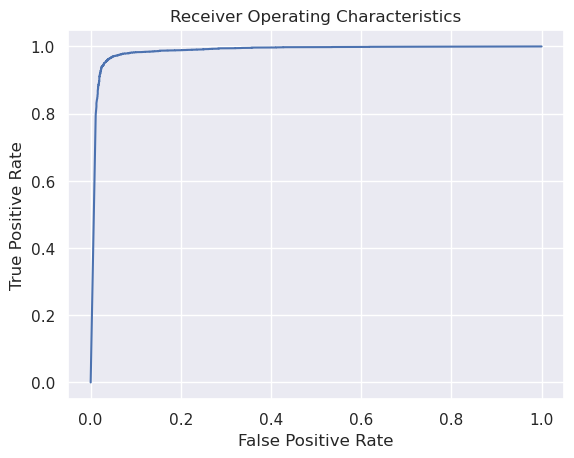

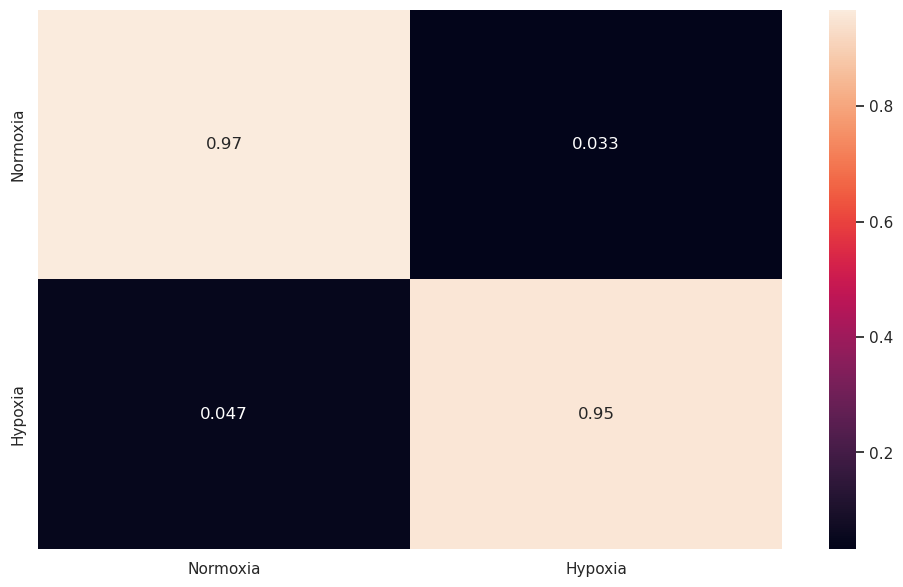

In [86]:
measure_model(model, test_loader)

F1 Score: 0.9090909090909091
Recall: 1.0
Accuracy of the network on the 88 test images: 100.0%


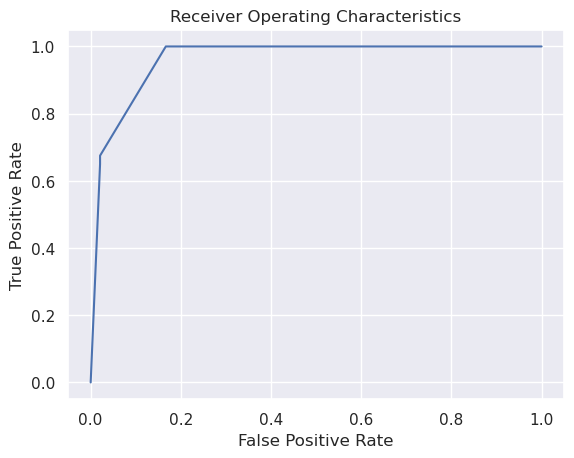

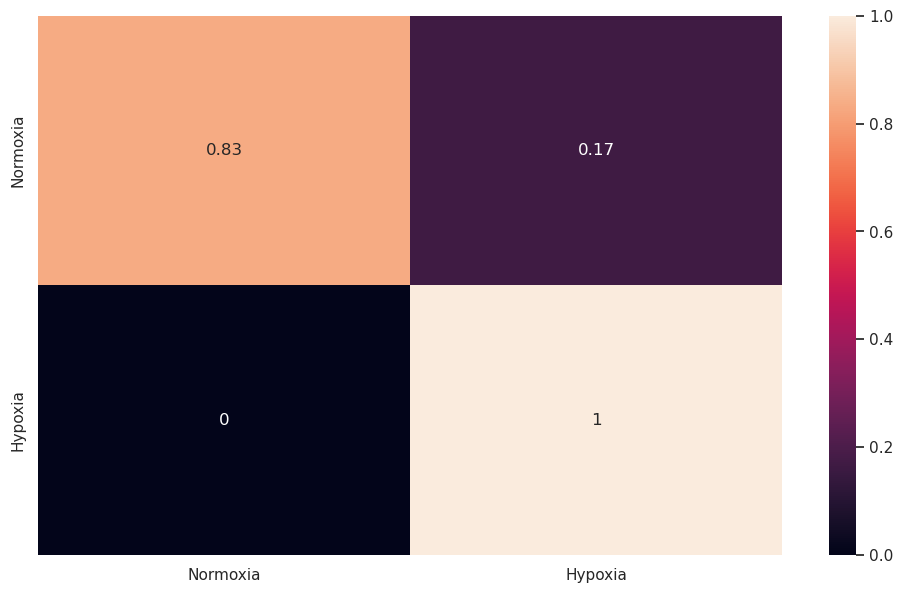

In [87]:
measure_model(model, test_loader_smart)

F1 Score: 0.9596705481397331
Recall: 0.9526360304482662
Accuracy of the network on the 7260 test images: 97.68595041322314%


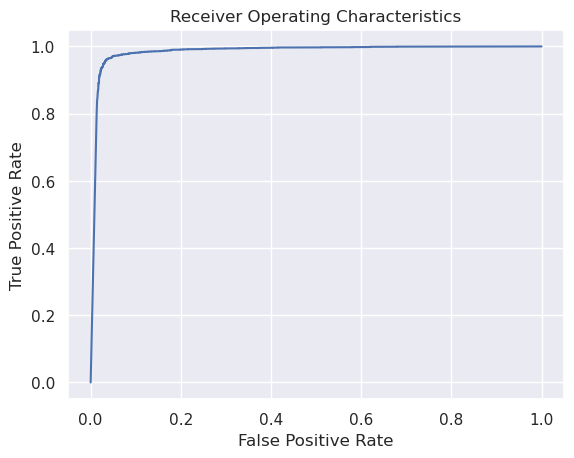

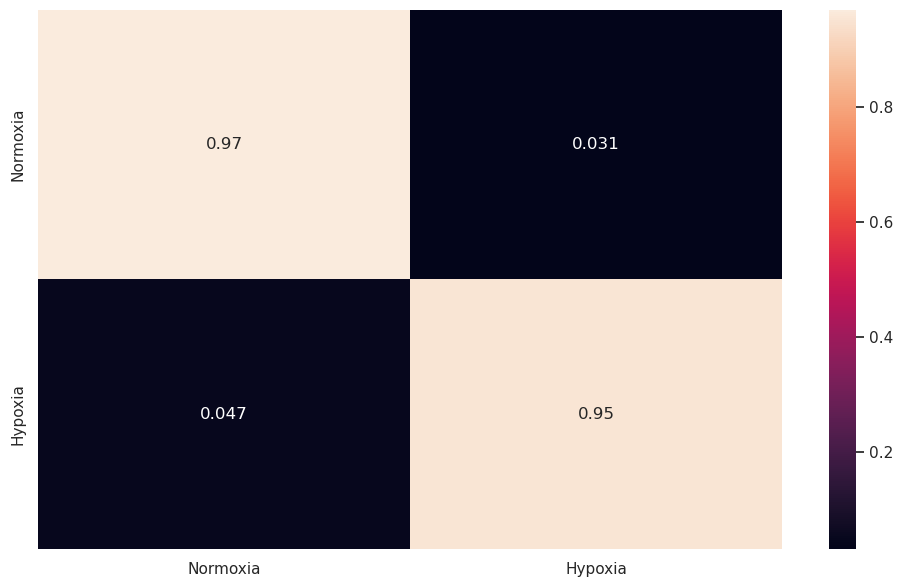

In [88]:

measure_model(model, test_loader_drop)

In [241]:
torch.save(model.state_dict(), "Model_with_smart_mcf.checkpoint")